In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt

DIR = "../dataset/"

def preprocess_and_generate():
    data_x = pd.read_csv(DIR + "data_X.csv", decimal=',')
    data_y = pd.read_csv(DIR + "data_Y.csv", decimal=',')
    submit_y = pd.read_csv(DIR+'sample_submission.csv', sep=',')
    print(data_x.columns, data_y.columns, submit_y.columns)
    print(len(data_x), len(data_y), len(submit_y))
    data_x["H_data"] = data_x["H_data"].astype("float")
    data_x["AH_data"] = data_x["AH_data"].astype("float")
    data_x["date"] = pd.to_datetime(data_x['date_time'])
    data_x1 = data_x.set_index(data_x["date"])
    data_x1.drop("date", axis=1, inplace=True)
    start = pd.to_datetime(data_y["date_time"].iloc[0]) - pd.Timedelta('0 days 01:00:00')
    end = data_y["date_time"].iloc[-1]
    # set the 2_hour_before signal to the data_x. simple set all the fake quality label. better add gaussian noise
    fake_label = np.concatenate([data_y["quality"].values.reshape(-1, 1)] * 60, axis=1).reshape(-1, 1)
    data_x1 = data_x1.loc[start:end][1:]
    data_x1["2_hours_before"] = fake_label
    return data_x1, data_y
pre_x, pre_y = preprocess_and_generate()

Index(['date_time', 'T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1',
       'T_data_2_2', 'T_data_2_3', 'T_data_3_1', 'T_data_3_2', 'T_data_3_3',
       'T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'T_data_5_1', 'T_data_5_2',
       'T_data_5_3', 'H_data', 'AH_data'],
      dtype='object') Index(['date_time', 'quality'], dtype='object') Index(['date_time', 'quality'], dtype='object')
2103841 29184 5808


Binning: T_data_1_1


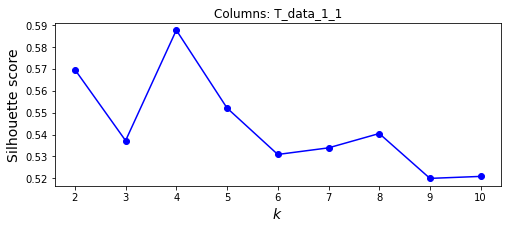

Binning: T_data_1_2


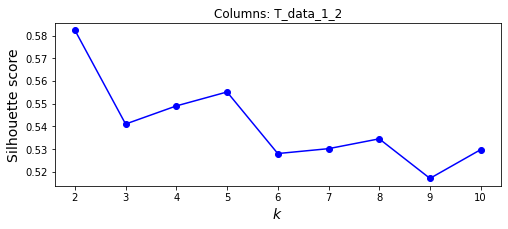

Binning: T_data_1_3


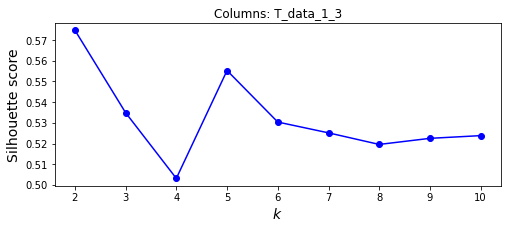

Binning: T_data_2_2


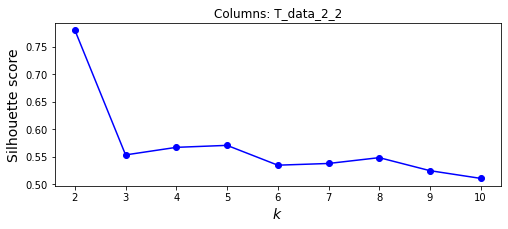

Binning: T_data_2_3


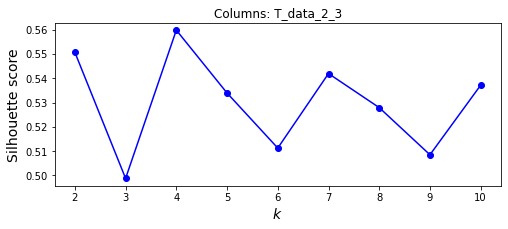

Binning: T_data_3_1


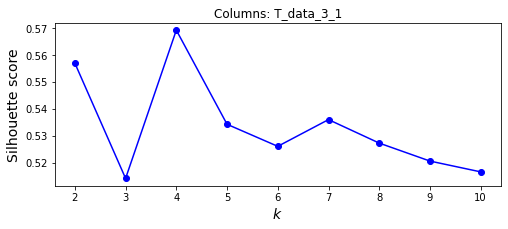

Binning: T_data_3_2


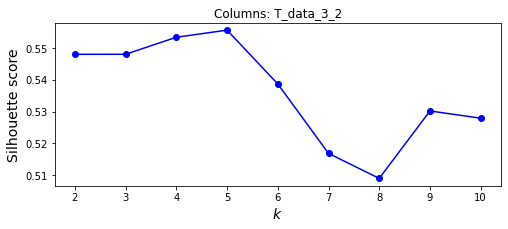

Binning: T_data_3_3


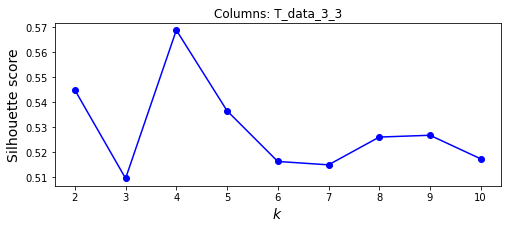

Binning: T_data_5_1


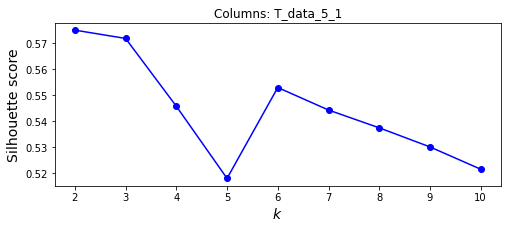

Binning: T_data_5_2


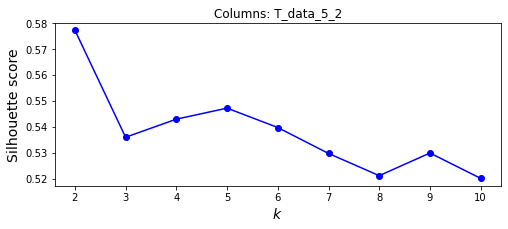

Binning: T_data_5_3


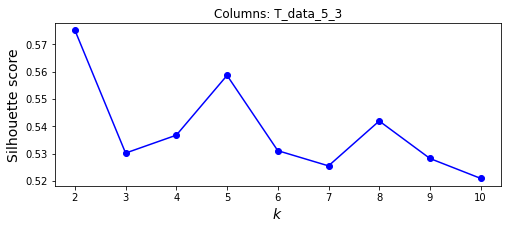

Binning: H_data


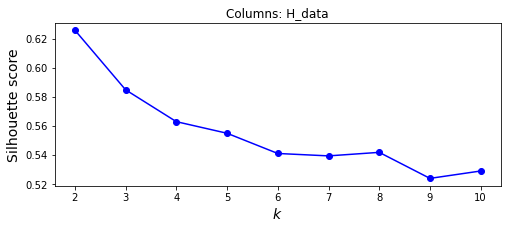

Binning: 2_hours_before


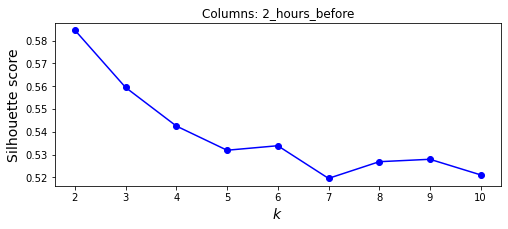

In [2]:
import os
os.chdir("..")
from utils.file import *

def visualize_kmeans(pre_x, bin_max=5, strategy="kmeans", sample_size=10000):
    assert strategy in ["uniform", "quantile", "kmeans"]
    cols = pre_x.columns.tolist()[1:]  # delete the datetime
    col_leave = read_pickle_from_file("dataset/split_features.pickle")
    cols = [col for col in cols if col in col_leave]
    for col in cols:
        print("Binning: {0}".format(col))
        silhouette_scores = []
        for k in range(2, bin_max+1):
            kmeans_per_k = KBinsDiscretizer(n_bins=k, encode='ordinal',strategy=strategy)
            kmeans_per_k.fit(pre_x[[col]])
            labels = kmeans_per_k.transform(pre_x[[col]])
            silhouette_scores.append(silhouette_score(pre_x[[col]], labels.flatten(), sample_size=sample_size))
        plt.figure(figsize=(8, 3))
        plt.plot(range(2, bin_max+1), silhouette_scores, "bo-")
        plt.xlabel("$k$", fontsize=14)
        plt.ylabel("Silhouette score", fontsize=14)
        plt.title("Columns: {}".format(col))
        plt.show()

visualize_kmeans(pre_x, bin_max=10, strategy="kmeans", sample_size=5000)

In [8]:
cols = pre_x.columns.tolist()[1:]  # delete the datetime
col_leave = read_pickle_from_file("dataset/split_features.pickle")
cols = [col for col in cols if col in col_leave]
cols

['T_data_1_1',
 'T_data_1_2',
 'T_data_1_3',
 'T_data_2_2',
 'T_data_2_3',
 'T_data_3_1',
 'T_data_3_2',
 'T_data_3_3',
 'T_data_5_1',
 'T_data_5_2',
 'T_data_5_3',
 'H_data',
 '2_hours_before']

In [12]:
# Although some features are discretized, they are not selected for training
# the best 2 may indicate that this feature is not suitable for binning, or should be carefully discrete
indicator_dims = [4, 2, 2, 2, 4, 4, 5, 4, 2, 2, 2, 2, 2] 
field_dims = [4, 5, 5, 2, 4, 20, 20, 20, 6, 5, 5, 10, 30]

def discrete_kmeans(pre_x, strategy="kmeans",bin_dims=None):
    assert strategy in ["uniform", "quantile", "kmeans"]
    cols = pre_x.columns.tolist()[1:]  # delete the datetime
    col_leave = read_pickle_from_file("dataset/split_features.pickle")
    cols = [col for col in cols if col in col_leave]
    for i, col in enumerate(cols):
        print("Binning: {0}".format(col))
        col_new = col + "_bin"
        kmeans_per_k = KBinsDiscretizer(n_bins=bin_dims[i], encode='ordinal',strategy=strategy)
        kmeans_per_k.fit(pre_x[[col]])
        labels = kmeans_per_k.transform(pre_x[[col]])
        pre_x[col_new] = labels
    return pre_x

pre_xx = discrete_kmeans(pre_x, strategy="kmeans",bin_dims=field_dims)

Binning: T_data_1_1
Binning: T_data_1_2
Binning: T_data_1_3
Binning: T_data_2_2
Binning: T_data_2_3
Binning: T_data_3_1
Binning: T_data_3_2
Binning: T_data_3_3
Binning: T_data_5_1
Binning: T_data_5_2
Binning: T_data_5_3
Binning: H_data
Binning: 2_hours_before


In [ ]:
"""
Based on the aformentional analysis, we can discrete part of the features
It is worth noticed that this score only guides us to choose the appropriate binning size, 
not a mandatory requirement. On the other hand, carefully binning can reduce the loss 
of information, but the parameters of embedding layer are increased. 
Therefore, the binning size should be considered carefully.
"""